# Dimensionality Reduction
On this notebook we will compare different techniques for dimensionality reduction (and clustering)
* PCA
* UMAP

#### Use case (scRNA-seq)
The ability to isolate and sequence the genetic material of single cells allows researchers to identify which genes are active in each cell.

#### References
* https://towardsdatascience.com/tsne-vs-umap-global-structure-4d8045acba17
* https://towardsdatascience.com/guide-to-dimensionality-reduction-in-single-cell-rna-seq-analysis-1d77284eed1c
* [Original Implementation](https://github.com/CrazyDaffodils/scRNA)
* [Data Visualization with Seaborn](https://jovianlin.io/data-visualization-seaborn-part-3/)
* [The Cancer Genome Atlas Pan-Cancer analysis project](https://www.nature.com/articles/ng.2764)

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

#### Get Dataset
This dataset is part of the RNA-Seq (HiSeq) PANCAN data set, it is a random extraction of gene expressions of patients having different types of tumor: BRCA, KIRC, COAD, LUAD and PRAD.
* Breast Cancer
* Kidney Renal Clear Cell Carcinoma
* Colon Adenocarcinoma
* Lung Cancer
* Prostate Adenocarcinoma

On this data have 20531 different genes (all genes that express proteins) and 801 different cancer patients.

The dataset can be downloaded here from [kaggle](https://www.kaggle.com/murats/gene-expression-cancer-rnaseq#data.csv) or [here](http://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#)

This data has a lot of "dimensions" (20531D), we can only vizualize things on 3D, and it's not safe to consider that our data live into a linear manifold.


In [2]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz .
!tar -vxzf TCGA-PANCAN-HiSeq-801x20531.tar.gz

--2020-04-09 20:59:55--  http://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72856320 (69M) [application/x-httpd-php]
Saving to: ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz.5’

TCGA-PANCAN-HiSeq-8 100%[===================>]  69.48M  16.0MB/s    in 5.0s    

2020-04-09 21:00:00 (13.9 MB/s) - ‘TCGA-PANCAN-HiSeq-801x20531.tar.gz.5’ saved [72856320/72856320]

--2020-04-09 21:00:00--  http://./
Resolving . (.)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘.’
FINISHED --2020-04-09 21:00:00--
Total wall clock time: 5.0s
Downloaded: 1 files, 69M in 5.0s (13.9 MB/s)
TCGA-PANCAN-HiSeq-801x20531/
TCGA-PANCAN-HiSeq-801x20531/data.csv
TCGA-PANCAN-HiSeq-801x20531/labels.csv


In [3]:
data = pd.read_csv('./TCGA-PANCAN-HiSeq-801x20531/data.csv', delimiter=',',index_col=0)
labels = pd.read_csv('./TCGA-PANCAN-HiSeq-801x20531/labels.csv', delimiter=',')
features = data.values
print('Types of cancer:', labels['Class'].unique())
print('Number of genes:', data.shape[1])

Types of cancer: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']
Number of genes: 20531


In [4]:
data.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [5]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


#### Normalize features
The idea is to make all values fall into similar range without loosing information, here we want the distribution of this data to be (mean=0,standard deviation =1)

In [6]:
features = StandardScaler().fit_transform(features)

### Vizualize High Dimension Data
We're trying here to vizualize 4 dimensions at the same time.

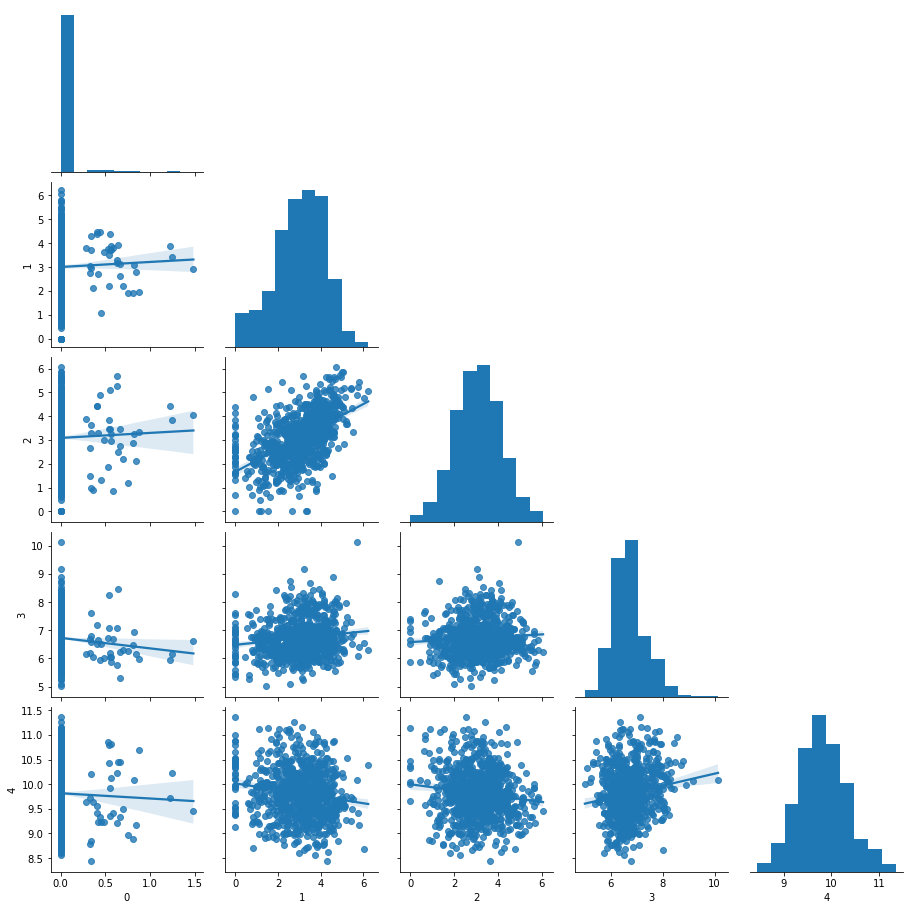

In [7]:
#g = sns.pairplot(features)
all_data = pd.DataFrame(data=data.values[:,0:5]).join(labels['Class'])
g = sns.pairplot(all_data, corner=True, kind="reg")#, hue="Class")

#### Use Principal Components Analysys (PCA)
Here we can see that PCA is having a hard job to differentiate those clusters. Here we're trying to find a linear plane that fit's into the 20531 

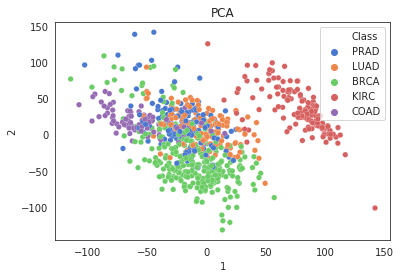

In [8]:
pca = PCA(n_components = 2).fit_transform(features)
pca_df = pd.DataFrame(data=pca, columns=['1','2']).join(labels)
palette = sns.color_palette("muted", n_colors=5)
sns.set_style("white")
sns.scatterplot(x='1',y='2',hue='Class',data=pca_df, palette=palette, linewidth=0.2, s=30, alpha=1).set_title('PCA');

#### Trying to see with 3D
Here we're giving PCA an extra dimension to try to fit. But again the algorithm fail to find the groups.

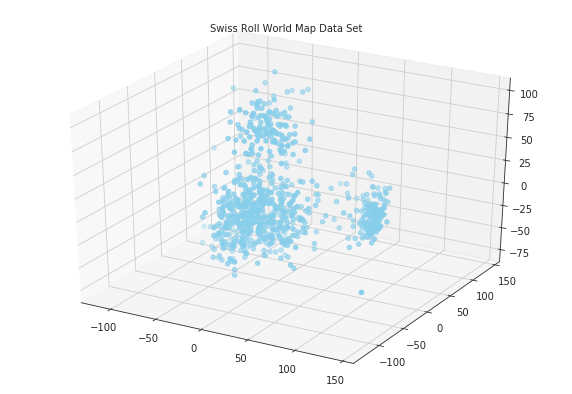

In [9]:
pca = PCA(n_components = 3).fit_transform(features)
pca_df = pd.DataFrame(data=pca, columns=['1','2', '3']).join(labels)
palette = sns.color_palette("muted", n_colors=5)
sns.set_style("white")

plt.figure(figsize=(10,7))
ax = plt.axes(projection = '3d')
#ax.scatter3D(pca_df.values[:, 0], pca_df.values[:, 1], pca_df.values[:, 2], c = labels.values[:,1])
ax.scatter3D(pca_df['1'], pca_df['2'], pca_df['3'], c='skyblue')
plt.title('Swiss Roll World Map Data Set', fontsize = 10);
plt.show()

#### Use UMAP

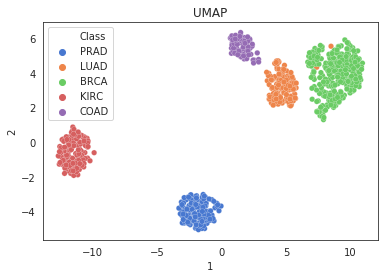

In [10]:
model = UMAP(n_neighbors = 40, min_dist = 0.4, n_components = 2)
umap = model.fit_transform(features)
umap_df = pd.DataFrame(data=umap, columns=['1','2']).join(labels)
palette = sns.color_palette("muted", n_colors=5)
sns.set_style("white")
sns.scatterplot(x='1',y='2',hue='Class',data=umap_df, palette=palette, linewidth=0.2, s=30, alpha=1).set_title('UMAP');